Old version

New correct u and v version. 

With lower Nueron and trial number

In [134]:
# ===============================================================
#  DESTINODE with neuron & lap subsampling  (variable‑K, u‑decoder)
# ===============================================================
import numpy as np, torch, matplotlib.pyplot as plt, torch.nn as nn, random
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint

# ------------------- 0. KNOBS -------------------
KEEP_NEURON_FRAC = 0.05          # 0–1   (20 % of neurons)
KEEP_LAP_FRAC    = 0.4          # 0–1   (50 % of laps per session)
RNG_SEED         = 42            # for reproducibility
torch.manual_seed(RNG_SEED); np.random.seed(RNG_SEED); random.seed(RNG_SEED)

# ------------------ 1. SETTINGS ------------------
SUBSET_FILE   = "destin_debug_subset.npz"
rank          = 3
train_days    = [0, 1, 2, 3]
test_day      = 6
epochs        = 50
LAMBDA_SMOOTH = 5e-2
device        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------ 2. LOAD & SUBSAMPLE ----------
data = np.load(SUBSET_FILE, allow_pickle=True)
sess_ids = sorted({int(k.split('_')[1]) for k in data if k.startswith('dff_')})

# 2a. decide once‑and‑for‑all neuron mask
N_full = data['dff_0'].shape[0]
n_keep = int(np.ceil(N_full * KEEP_NEURON_FRAC))
keep_neurons = np.random.choice(N_full, n_keep, replace=False)
keep_neurons.sort()                                      # keep order

to_tensor = lambda x: torch.tensor(x, dtype=torch.float32)
x_sess = []; v_sess = []; u_sess = []
for t in sess_ids:
    dff_full = data[f'dff_{t}'][keep_neurons]             # [N_keep, K_vr]
    dff_full = to_tensor(dff_full.T)                      # [K_vr, N_keep]
    vel_full = to_tensor(data[f'vel_{t}'])
    pos_full = to_tensor(data[f'pos_{t}'])
    pos_full = (pos_full - pos_full.mean()) / pos_full.std()

    lap_idx  = data[f'lap_idx_{t}']

    # 2b. optional lap subsampling
    all_laps = np.unique(lap_idx)
    n_laps_keep = int(np.ceil(len(all_laps) * KEEP_LAP_FRAC))
    keep_laps = np.random.choice(all_laps, n_laps_keep, replace=False)

    laps_x = []; laps_v = []; laps_u = []
    for s in sorted(keep_laps):
        mask = lap_idx == s
        if not mask.any(): continue
        laps_x.append(dff_full[mask])
        laps_v.append(vel_full[mask])
        laps_u.append(pos_full[mask])

    x_sess.append(laps_x); v_sess.append(laps_v); u_sess.append(laps_u)

T, N = len(x_sess), len(keep_neurons)
print(f"Sessions: {T} | Neurons kept: {N}/{N_full} "
      f"| Example lap shape: {x_sess[0][0].shape}")

# ------------------ 3. DATASET -------------------
class RaggedSplitDS(Dataset):
    def __init__(self, x, v, u, days):
        self.x,self.v,self.u = x,v,u
        self.map = [(t,s) for t in days for s in range(len(x[t]))]
    def __len__(self): return len(self.map)
    def __getitem__(self, idx):
        t,s = self.map[idx]
        return self.x[t][s], self.v[t][s], self.u[t][s], t

loader = DataLoader(RaggedSplitDS(x_sess,v_sess,u_sess,train_days),
                    batch_size=1, shuffle=True, collate_fn=lambda b:b)

# ------------------ 4. MODEL (unchanged except N) -----------
W0 = 0.05*torch.randn(N,N)
U,_,Vt = torch.linalg.svd(W0)
U = U[:,:rank]; V = Vt[:rank,:].T
B = 0.05*torch.randn(N,1); R = 0.05*torch.randn(1,N)

# ===============================================================
#  DAY‑0‑DRIVEN INITIALISATION  (insert before “# ------------------ 4. MODEL ---------------------”)
# ===============================================================
print("‣ deriving Day‑0 statistics for W0 and b_fixed …")

# -------- gather all frames from session‑0 after subsampling --------
X0 = torch.cat(x_sess[0], dim=0)           # [K_total_day0 , N]
X0 = X0.float()                            # ensure fp32

# -------- 1) activation bias  b_fixed -------------------------------
avg_rate = X0.mean(0)                      # mean across time
b_init   = -(avg_rate - avg_rate.mean())   # anti‑correlated w/ firing
b_init   = (0.5 / b_init.abs().max()) * b_init   # scale to ±0.5

# # -------- 2) connectivity seed  W0 ---------------------------------
# #   use Pearson correlation matrix of day‑0 activity
# X0c   = X0 - avg_rate                      # centre
# std   = X0c.std(0, unbiased=False) + 1e-9
# corr  = (X0c.T @ X0c) / X0c.shape[0]
# corr  = corr / (std[:,None] * std[None,:]) # now ρ_{ij} in [‑1,1]
# W0_init = 0.05 * corr                      # match earlier 0.05 scale

# # -------- 3) low‑rank bases from new W0 ----------------------------
# U,_,Vt = torch.linalg.svd(W0_init.cpu())
# U = U[:,:rank]; V = Vt[:rank,:].T

# print(f"   » b range  {b_init.min():.2f} … {b_init.max():.2f}")
# print(f"   » W0 diag mean±sd  {W0_init.diag().mean():.3f} ± {W0_init.diag().std():.3f}")

# # keep tensors for the model section
# W0 = W0_init.clone()
# B  = 0.05 * torch.randn(N,1)
# R  = 0.05 * torch.randn(1,N)


class SlowODE(nn.Module):
    def __init__(self,r):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(r,64), nn.Tanh(), nn.Linear(64,r))
    def forward(self,t,z): return self.net(z)

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.U,self.V,self.W0 = U.to(device), V.to(device), W0.to(device)
        self.z0 = nn.Parameter(torch.zeros(rank))
        self.slow = SlowODE(rank)
        self.B = nn.Parameter(B.clone()); self.R = nn.Parameter(R.clone())
        self.b_fixed = nn.Parameter(torch.zeros(N), requires_grad=True)
        # self.b_fixed = nn.Parameter(b_init.to(device), requires_grad=False)

    def weights(self,T):
        t = torch.arange(T, dtype=torch.float32, device=self.z0.device)
        z = odeint(self.slow, self.z0[None], t).squeeze(1)       # [T,r]
        Ud   = self.U[None] * z[:,None]                          # [T,N,r]
        Vt   = self.V.T.expand(T, -1, -1)                        # [T,r,N]
        Wadd = torch.bmm(Ud, Vt)                                 # [T,N,N]
        return self.W0[None] + Wadd
    def rnn_cell(self,xk,vk,W):
        return torch.tanh(W@xk + (self.B*vk).squeeze() + self.b_fixed)
    def forward(self,x_gt,v_seq,u_seq,t_idx,Ws):
        K = x_gt.size(0); W = Ws[t_idx]
        rec = dec = 0.; x_prev = x_gt[0]
        for k in range(K-1):
            x_pred = self.rnn_cell(x_prev, v_seq[k], W)
            rec += (x_pred - x_gt[k+1]).pow(2).sum()
            dec += (self.R @ x_pred - u_seq[k]).pow(2)
            x_prev = x_pred
            # ----- inside PINN.forward  (keep all code above unchanged) -----
            lambda_rec = 1.0      # full weight on reconstruction
            lambda_dec = 0.1      # put decoder on same numeric scale

        return lambda_rec * rec + lambda_dec * dec
        

model = PINN().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-4)

# ------------------ 5. TRAIN ---------------------
for ep in range(epochs):
    total=0.
    for batch in loader:
        Ws = model.weights(T)
        losses=[]
        for x_gt,v_gt,u_gt,t_idx in batch:
            x_gt,v_gt,u_gt = (x_gt.to(device), v_gt.to(device), u_gt.to(device))
            losses.append(model(x_gt,v_gt,u_gt,t_idx,Ws))
        rec_dec = torch.stack(losses).mean()
        smooth  = (Ws[1:]-Ws[:-1]).pow(2).sum()
        loss = rec_dec + LAMBDA_SMOOTH*smooth
        opt.zero_grad(); loss.backward(); opt.step(); total+=loss.item()
    if ep%5==0:
        print(f"Epoch {ep:03d} | total {total/len(loader):.3e} "
              f"| rec+dec {rec_dec.item():.3e}")




Sessions: 8 | Neurons kept: 16/305 | Example lap shape: torch.Size([668, 16])
‣ deriving Day‑0 statistics for W0 and b_fixed …
Epoch 000 | total 3.649e+03 | rec+dec 3.429e+03
Epoch 005 | total 2.192e+03 | rec+dec 1.854e+03
Epoch 010 | total 8.811e+02 | rec+dec 9.773e+02
Epoch 015 | total 5.657e+02 | rec+dec 8.556e+02
Epoch 020 | total 5.476e+02 | rec+dec 6.504e+02
Epoch 025 | total 5.438e+02 | rec+dec 7.545e+02
Epoch 030 | total 5.410e+02 | rec+dec 3.101e+02
Epoch 035 | total 5.390e+02 | rec+dec 6.378e+02
Epoch 040 | total 5.374e+02 | rec+dec 3.412e+02
Epoch 045 | total 5.362e+02 | rec+dec 5.068e+02


/var/folders/zl/dq7c13p16bsb4qhmx8fvgp2m0000gn/T/ipykernel_42107/2802726413.py:21: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.tight_layout(); plt.show()
/Users/Erfan/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


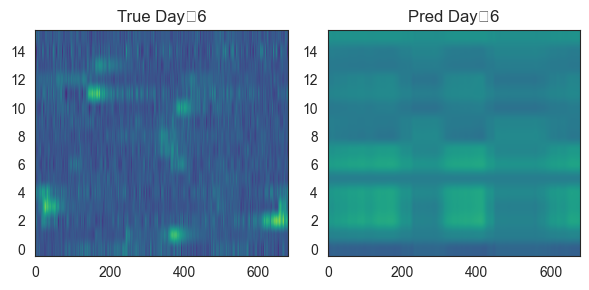

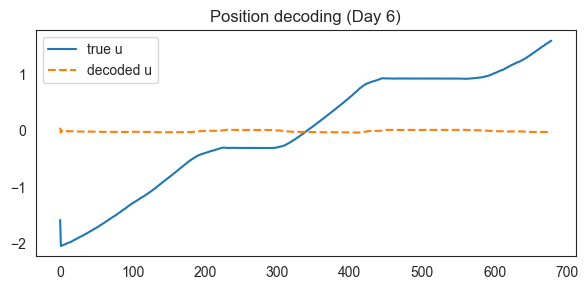

In [135]:
# ------------------ 6. EXTRAPOLATE (unchanged) --------------
Ws = model.weights(T)
x_true = x_sess[test_day][0].to(device)
v_true = v_sess[test_day][0].to(device)
u_true = u_sess[test_day][0].cpu().numpy()
K_seq  = v_true.size(0); W6 = Ws[test_day]

x_pred=[x_true[0]]
for k in range(K_seq-1):
    x_pred.append(model.rnn_cell(x_pred[-1], v_true[k], W6))
# x_pred=torch.stack(x_pred); u_pred=(model.R@x_pred.T).squeeze().cpu().numpy()
# option 1 — detach before moving to CPU
x_pred = torch.stack(x_pred).detach()             # no grad on x_pred
u_pred = (model.R @ x_pred.T).squeeze().detach().cpu().numpy()


plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(x_true.T.cpu(),aspect='auto',origin='lower',cmap='viridis')
plt.title("True Day‑6"); plt.subplot(1,2,2)
plt.imshow(x_pred.T.cpu(),aspect='auto',origin='lower',cmap='viridis'); plt.title("Pred Day‑6")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(u_true,label='true u'); plt.plot(u_pred,'--',label='decoded u')
plt.title("Position decoding (Day 6)"); plt.legend(); plt.tight_layout(); plt.show()

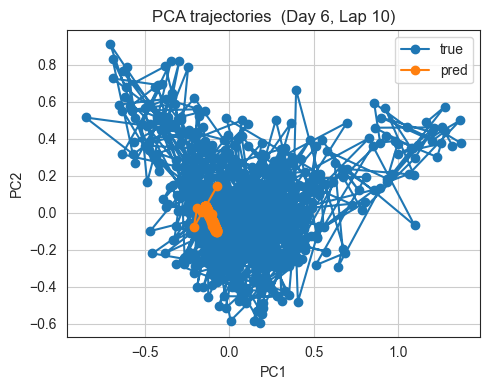

/var/folders/zl/dq7c13p16bsb4qhmx8fvgp2m0000gn/T/ipykernel_42107/1501156981.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.suptitle('PC space coloured by position'); plt.tight_layout(); plt.show()


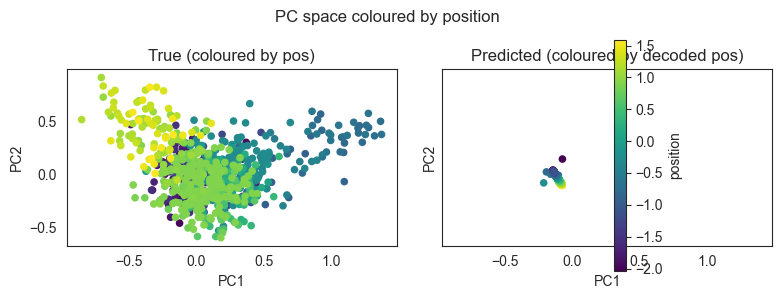

/var/folders/zl/dq7c13p16bsb4qhmx8fvgp2m0000gn/T/ipykernel_42107/1501156981.py:70: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  ax.legend(); plt.tight_layout(); plt.show()
/Users/Erfan/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


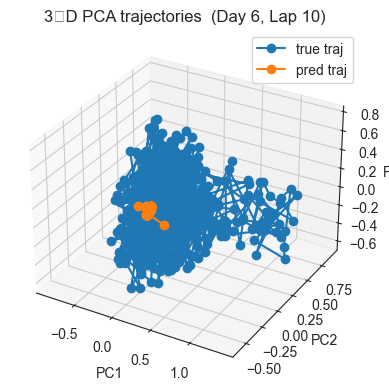

/var/folders/zl/dq7c13p16bsb4qhmx8fvgp2m0000gn/T/ipykernel_42107/1501156981.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.suptitle('3‑D PC space coloured by position'); plt.tight_layout(); plt.show()
/var/folders/zl/dq7c13p16bsb4qhmx8fvgp2m0000gn/T/ipykernel_42107/1501156981.py:90: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.suptitle('3‑D PC space coloured by position'); plt.tight_layout(); plt.show()


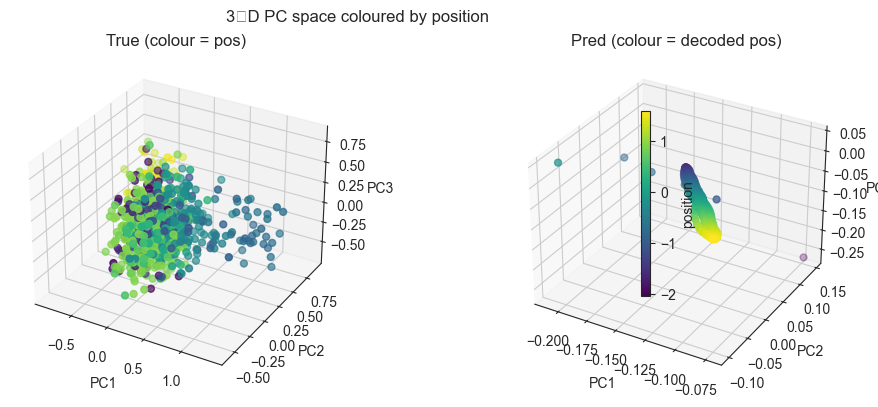

/var/folders/zl/dq7c13p16bsb4qhmx8fvgp2m0000gn/T/ipykernel_42107/1501156981.py:112: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.suptitle('Place‑field maps'); plt.tight_layout(); plt.show()
/Users/Erfan/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


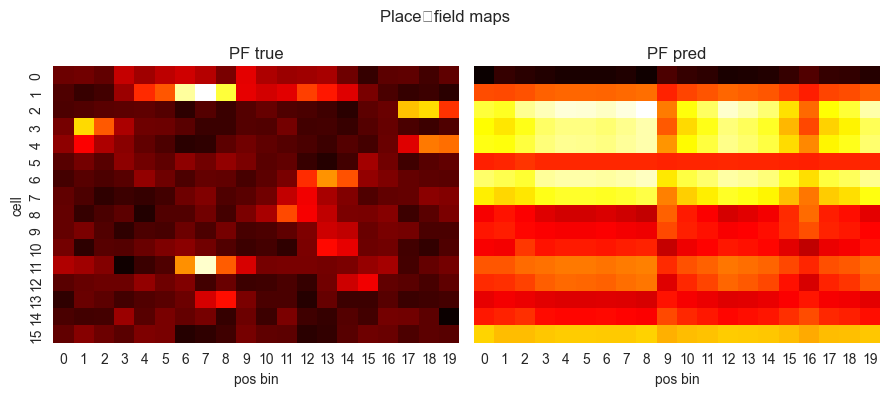

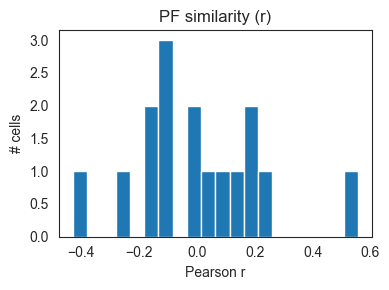

PF r  mean=0.012  ±0.056  (n=16)


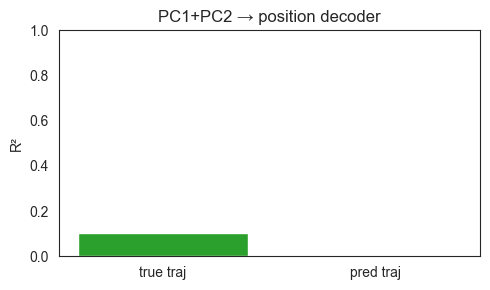

PCA‑decoder  R² true=0.101   R² pred=-0.056


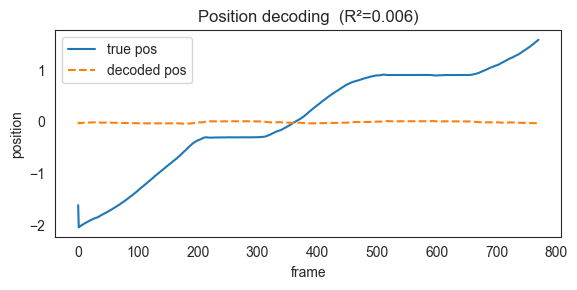

In [146]:
# ===============================================================
#  ADVANCED VISUALS + METRICS  (v2 — PC‑space vs position)
# ===============================================================
import numpy as np, torch, matplotlib.pyplot as plt, seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

sns.set_style("white")

# ------------------ 0. KNOBS ------------------
REST_DAY  = 6     # session index to analyse
LAP_ID    = 10      # lap index within the session
NUM_BINS  = 20     # spatial bins for place‑field maps

# ------------------ 1. RECONSTRUCT LAP --------
Ws = model.weights(T)
x_true = x_sess[REST_DAY][LAP_ID].to(device)        # [K, N]
v_true = v_sess[REST_DAY][LAP_ID].to(device)
u_true = u_sess[REST_DAY][LAP_ID].cpu().numpy()
K_seq  = v_true.size(0)
W_rest = Ws[REST_DAY]

with torch.no_grad():
    x_pred = [x_true[0]]
    for k in range(K_seq-1):
        x_pred.append(model.rnn_cell(x_pred[-1], v_true[k], W_rest))
    x_pred = torch.stack(x_pred).cpu()              # [K, N]
    u_pred = (model.R @ x_pred.T).squeeze().cpu().numpy()

# ------------------ 2. PCA overlay ------------
comb = torch.cat([x_true.cpu(), x_pred], dim=0).numpy()  # [2K, N]
pca   = PCA(n_components=2).fit(comb)
proj  = pca.transform(comb)
true_proj, pred_proj = proj[:K_seq], proj[K_seq:]

plt.figure(figsize=(5,4))
plt.plot(true_proj[:,0], true_proj[:,1], 'o-', label='true')
plt.plot(pred_proj[:,0], pred_proj[:,1], 'o-', label='pred')
plt.title(f'PCA trajectories  (Day {REST_DAY}, Lap {LAP_ID})')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ------------------ 3. Colour‑by‑position -----
fig, axs = plt.subplots(1,2, figsize=(8,3), sharex=True, sharey=True)
sc0 = axs[0].scatter(true_proj[:,0], true_proj[:,1], c=u_true, cmap='viridis', s=20)
axs[0].set_title('True (coloured by pos)')
sc1 = axs[1].scatter(pred_proj[:,0], pred_proj[:,1], c=u_pred, cmap='viridis', s=20)
axs[1].set_title('Predicted (coloured by decoded pos)')
for ax in axs: ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
fig.colorbar(sc0, ax=axs.ravel().tolist(), label='position')
fig.suptitle('PC space coloured by position'); plt.tight_layout(); plt.show()



# ===============================================================
# 2′.  THREE‑D PCA OVERLAY  (true vs predicted)
# ===============================================================
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401  (needed for 3‑D)

pca3  = PCA(n_components=3).fit(comb)
proj3 = pca3.transform(comb)
true_p3, pred_p3 = proj3[:K_seq], proj3[K_seq:]

fig = plt.figure(figsize=(6,4))
ax  = fig.add_subplot(111, projection='3d')
ax.plot(true_p3[:,0], true_p3[:,1], true_p3[:,2], 'o-', label='true traj')
ax.plot(pred_p3[:,0], pred_p3[:,1], pred_p3[:,2], 'o-', label='pred traj')
ax.set_title(f'3‑D PCA trajectories  (Day {REST_DAY}, Lap {LAP_ID})')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.legend(); plt.tight_layout(); plt.show()

# ===============================================================
# 3′.  3‑D PC SPACE COLOURED BY POSITION
#      (left = true col’d by true‑pos, right = pred col’d by decoded‑pos)
# ===============================================================
fig = plt.figure(figsize=(10,4))
ax0 = fig.add_subplot(121, projection='3d')
p0  = ax0.scatter(true_p3[:,0], true_p3[:,1], true_p3[:,2],
                  c=u_true, cmap='viridis', s=25)
ax0.set_title('True (colour = pos)')
ax0.set_xlabel('PC1'); ax0.set_ylabel('PC2'); ax0.set_zlabel('PC3')

ax1 = fig.add_subplot(122, projection='3d')
p1  = ax1.scatter(pred_p3[:,0], pred_p3[:,1], pred_p3[:,2],
                  c=u_pred, cmap='viridis', s=25)
ax1.set_title('Pred (colour = decoded pos)')
ax1.set_xlabel('PC1'); ax1.set_ylabel('PC2'); ax1.set_zlabel('PC3')

fig.colorbar(p0, ax=[ax0,ax1], shrink=0.6, label='position')
fig.suptitle('3‑D PC space coloured by position'); plt.tight_layout(); plt.show()


# ------------------ 4. Place‑field maps --------
pos_bins = np.linspace(u_true.min(), u_true.max(), NUM_BINS+1)
bin_idx  = np.digitize(u_true, pos_bins) - 1

def pf_map(x):
    pf = np.zeros((NUM_BINS, x.shape[1]))
    for b in range(NUM_BINS):
        if not (bin_idx==b).any(): continue
        pf[b] = x[bin_idx==b].mean(0)
    return pf.T

pf_true = pf_map(x_true.cpu().numpy())
pf_pred = pf_map(x_pred.numpy())

fig,axs=plt.subplots(1,2,figsize=(9,4),sharey=True)
sns.heatmap(pf_true, ax=axs[0], cmap='hot', cbar=False)
sns.heatmap(pf_pred, ax=axs[1], cmap='hot', cbar=False)
axs[0].set_title('PF true'); axs[1].set_title('PF pred')
for ax in axs: ax.set_xlabel('pos bin'); axs[0].set_ylabel('cell')
fig.suptitle('Place‑field maps'); plt.tight_layout(); plt.show()

# ------------------ 5. PF similarity -----------
from scipy.stats import pearsonr
corrs=[pearsonr(pf_true[i],pf_pred[i])[0]
       for i in range(pf_true.shape[0]) if pf_true[i].std() and pf_pred[i].std()]

plt.figure(figsize=(4,3))
plt.hist(corrs,bins=20,color='C0');plt.title('PF similarity (r)')
plt.xlabel('Pearson r'); plt.ylabel('# cells'); plt.tight_layout(); plt.show()
print(f"PF r  mean={np.mean(corrs):.3f}  ±{np.std(corrs)/np.sqrt(len(corrs)):.3f}  (n={len(corrs)})")

# ------------------ 6. PCA‑decoder accuracy ----
reg = LinearRegression().fit(true_proj, u_true)
u_true_pca = reg.predict(true_proj)
u_pred_pca = reg.predict(pred_proj)

r2_true = r2_score(u_true, u_true_pca)
r2_pred = r2_score(u_true, u_pred_pca)

plt.figure(figsize=(5,3))
plt.bar(['true traj', 'pred traj'], [r2_true, r2_pred], color=['C2','C3'])
plt.ylim(0,1); plt.ylabel('R²'); plt.title('PC1+PC2 → position decoder'); plt.tight_layout(); plt.show()
print(f"PCA‑decoder  R² true={r2_true:.3f}   R² pred={r2_pred:.3f}")

# ------------------ 7. Time‑series decoding ----
plt.figure(figsize=(6,3))
plt.plot(u_true,label='true pos'); plt.plot(u_pred,'--',label='decoded pos')
plt.title(f'Position decoding  (R²={r2_score(u_true,u_pred):.3f})')
plt.xlabel('frame'); plt.ylabel('position'); plt.legend(); plt.tight_layout(); plt.show()


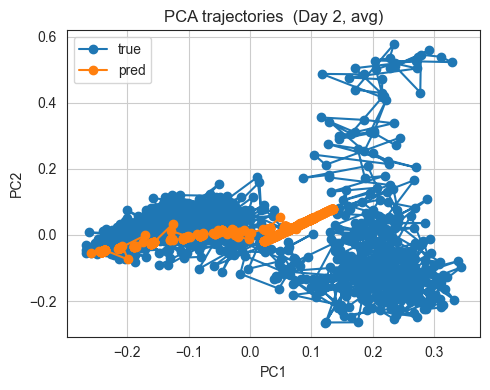

/var/folders/zl/dq7c13p16bsb4qhmx8fvgp2m0000gn/T/ipykernel_42107/2229738115.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


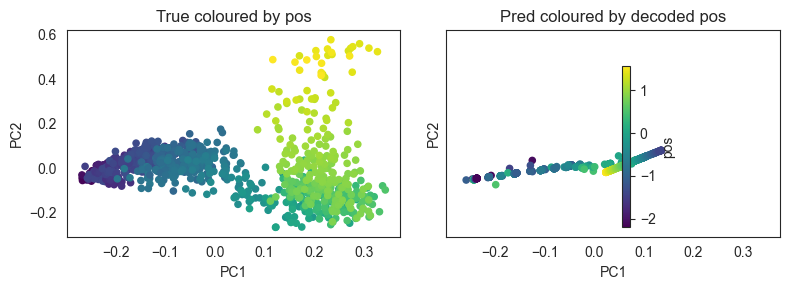

/var/folders/zl/dq7c13p16bsb4qhmx8fvgp2m0000gn/T/ipykernel_42107/2229738115.py:83: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  ax.legend(); plt.tight_layout(); plt.show()
/Users/Erfan/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


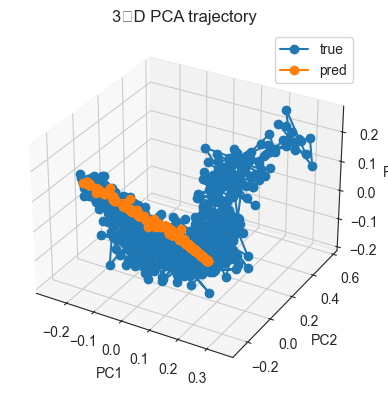

/var/folders/zl/dq7c13p16bsb4qhmx8fvgp2m0000gn/T/ipykernel_42107/2229738115.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.colorbar(sc,ax=[ax0,ax1],shrink=0.6,label='pos'); plt.tight_layout(); plt.show()


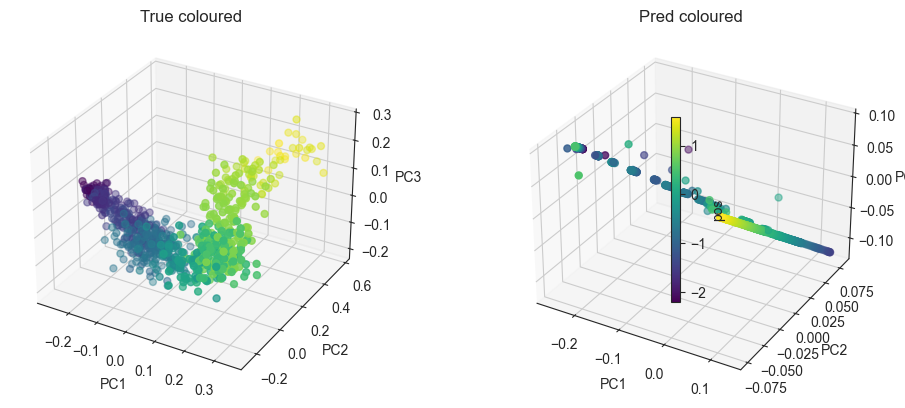

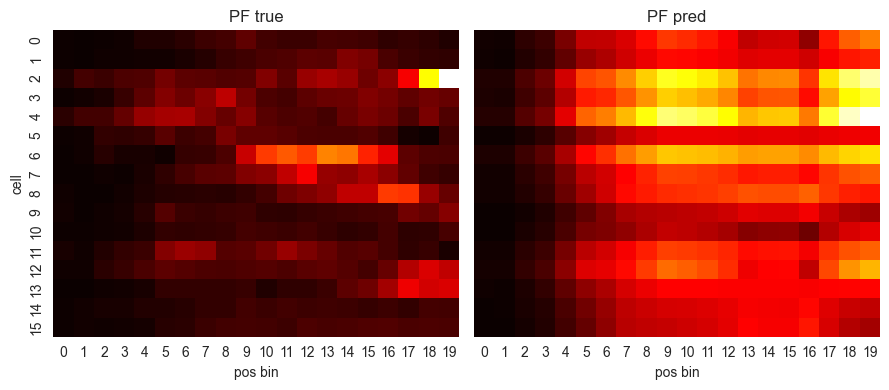

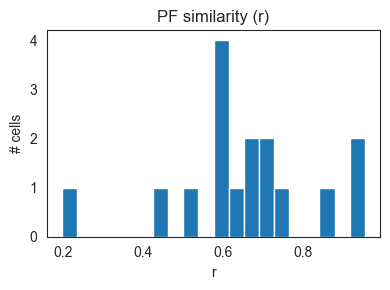

PF r mean=0.652 ± 0.045
PC decoder R²  true=0.910   pred=0.593


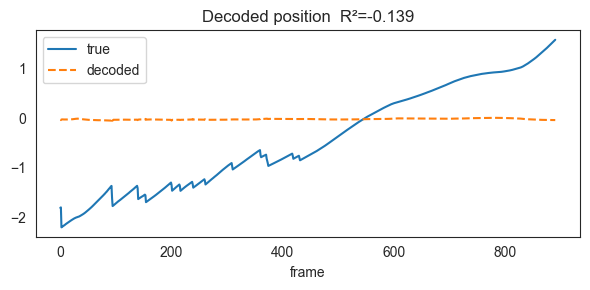

In [ ]:
# ===============================================================
#  ADVANCED VISUALS + METRICS  (with optional lap‑averaging)
# ===============================================================
import numpy as np, torch, matplotlib.pyplot as plt, seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
sns.set_style("white")

# ------------------ 0. KNOBS ------------------
REST_DAY      = 2      # which session to analyse
LAP_ID        = 3      # ignored if AVG_OVER_LAPS = True
NUM_BINS      = 20
AVG_OVER_LAPS = True   # <- turn ON to average across all laps on REST_DAY

# ------------------ 1. COLLECT / AVERAGE  ---------------------
Ws = model.weights(T)
W_day = Ws[REST_DAY]

def reconstruct(lap_idx):
    x_t = x_sess[REST_DAY][lap_idx].to(device)
    v_t = v_sess[REST_DAY][lap_idx].to(device)
    u_t = u_sess[REST_DAY][lap_idx].cpu().numpy()
    K   = v_t.size(0)
    with torch.no_grad():
        x_p=[x_t[0]]
        for k in range(K-1):
            x_p.append(model.rnn_cell(x_p[-1], v_t[k], W_day))
        x_p  = torch.stack(x_p).cpu()                    # [K,N]
        u_p  = (model.R @ x_p.T).squeeze().cpu().numpy() # [K]
    return x_t.cpu(), x_p, u_t, u_p, K

if AVG_OVER_LAPS:
    all_x_true = []; all_x_pred = []; all_u_true = []; all_u_pred = []
    K_max = max(len(v) for v in v_sess[REST_DAY])
    for li in range(len(x_sess[REST_DAY])):
        xT,xP,uT,uP,K = reconstruct(li)
        pad = (K_max-K,0)  # pad at *front* so starts align
        all_x_true.append(torch.nn.functional.pad(xT, pad=(0,0,*pad)))
        all_x_pred.append(torch.nn.functional.pad(xP, pad=(0,0,*pad)))
        all_u_true.append(np.pad(uT, pad, constant_values=np.nan))
        all_u_pred.append(np.pad(uP, pad, constant_values=np.nan))
    x_true = torch.stack(all_x_true).nanmean(0)   # [K_max,N]
    x_pred = torch.stack(all_x_pred).nanmean(0)
    u_true = np.nanmean(np.vstack(all_u_true),0)
    u_pred = np.nanmean(np.vstack(all_u_pred),0)
    K_seq  = K_max
else:  # single lap path
    x_true,x_pred,u_true,u_pred,K_seq = reconstruct(LAP_ID)[:5]

# ------------------ 2. PCA overlay (2‑D) ----------------------
comb = torch.cat([x_true, x_pred], dim=0).numpy()  # [2K,N]
pca2 = PCA(n_components=2).fit(comb)
proj2= pca2.transform(comb)
true_p2,pred_p2 = proj2[:K_seq], proj2[K_seq:]

plt.figure(figsize=(5,4))
plt.plot(true_p2[:,0], true_p2[:,1],'o-',label='true')
plt.plot(pred_p2[:,0], pred_p2[:,1],'o-',label='pred')
ttl = "avg" if AVG_OVER_LAPS else f"lap {LAP_ID}"
plt.title(f'PCA trajectories  (Day {REST_DAY}, {ttl})')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ------------------ 3. PC space colour‑by‑pos (2‑D) ----------
fig,axs=plt.subplots(1,2,figsize=(8,3),sharex=True,sharey=True)
axs[0].scatter(true_p2[:,0], true_p2[:,1], c=u_true, cmap='viridis', s=20)
axs[0].set_title('True coloured by pos')
axs[1].scatter(pred_p2[:,0], pred_p2[:,1], c=u_pred, cmap='viridis', s=20)
axs[1].set_title('Pred coloured by decoded pos')
for ax in axs: ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
fig.colorbar(axs[0].collections[0], ax=axs, shrink=0.7, label='pos')
plt.tight_layout(); plt.show()

# ------------------ 4. 3‑D PCA overlay -----------------------
pca3 = PCA(n_components=3).fit(comb); proj3=pca3.transform(comb)
true_p3,pred_p3 = proj3[:K_seq], proj3[K_seq:]

fig=plt.figure(figsize=(6,4)); ax=fig.add_subplot(111,projection='3d')
ax.plot(*true_p3.T,'o-',label='true'); ax.plot(*pred_p3.T,'o-',label='pred')
ax.set_title('3‑D PCA trajectory'); ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.legend(); plt.tight_layout(); plt.show()

# ------------------ 5. 3‑D colour‑by‑pos ---------------------
fig=plt.figure(figsize=(10,4))
ax0=fig.add_subplot(121,projection='3d')
sc=ax0.scatter(*true_p3.T,c=u_true,cmap='viridis',s=25); ax0.set_title('True coloured')
ax1=fig.add_subplot(122,projection='3d')
ax1.scatter(*pred_p3.T,c=u_pred,cmap='viridis',s=25); ax1.set_title('Pred coloured')
for ax in [ax0,ax1]:
    ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
fig.colorbar(sc,ax=[ax0,ax1],shrink=0.6,label='pos'); plt.tight_layout(); plt.show()

# ------------------ 6. Place‑field maps ----------------------
pos_bins=np.linspace(u_true.min(),u_true.max(),NUM_BINS+1)
bin_idx=np.digitize(u_true,pos_bins)-1
def pf(x):
    P=np.zeros((NUM_BINS,x.shape[1]))
    for b in range(NUM_BINS):
        if not (bin_idx==b).any(): continue
        P[b]=x[bin_idx==b].mean(0)
    return P.T
pf_true,pf_pred = pf(x_true.numpy()), pf(x_pred.numpy())

fig,axs=plt.subplots(1,2,figsize=(9,4),sharey=True)
sns.heatmap(pf_true,ax=axs[0],cmap='hot',cbar=False);axs[0].set_title('PF true')
sns.heatmap(pf_pred,ax=axs[1],cmap='hot',cbar=False);axs[1].set_title('PF pred')
for ax in axs: ax.set_xlabel('pos bin'); axs[0].set_ylabel('cell')
plt.tight_layout(); plt.show()

# ------------------ 7. PF similarity histogram --------------
corrs=[pearsonr(pf_true[i],pf_pred[i])[0]
       for i in range(pf_true.shape[0]) if pf_true[i].std() and pf_pred[i].std()]
plt.figure(figsize=(4,3)); plt.hist(corrs,bins=20,color='gray')
plt.title('PF similarity (r)'); plt.xlabel('r'); plt.ylabel('# cells'); plt.tight_layout(); plt.show()
print(f"PF r mean={np.mean(corrs):.3f} ± {np.std(corrs)/np.sqrt(len(corrs)):.3f}")

# ------------------ 8. PCA‑decoder accuracy ------------------
reg = LinearRegression().fit(true_p2, u_true)
print(f"PC decoder R²  true={r2_score(u_true, reg.predict(true_p2)):.3f}   "
      f"pred={r2_score(u_true, reg.predict(pred_p2)):.3f}")

# ------------------ 9. Time‑series decoding -----------------
plt.figure(figsize=(6,3))
plt.plot(u_true,label='true'); plt.plot(u_pred,'--',label='decoded')
plt.title(f'Decoded position  R²={r2_score(u_true,u_pred):.3f}')
plt.xlabel('frame'); plt.legend(); plt.tight_layout(); plt.show()


/var/folders/zl/dq7c13p16bsb4qhmx8fvgp2m0000gn/T/ipykernel_42107/2212449325.py:40: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.suptitle(f'Place‑field maps ({st})'); plt.tight_layout(); plt.show()
/Users/Erfan/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


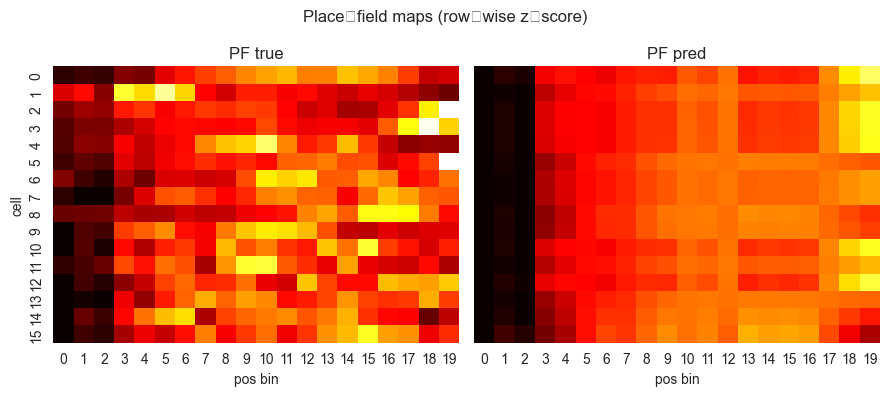

In [138]:
# ---------- Better place‑field visualisation ----------
def plot_pfs(pf_true, pf_pred, mode="global"):
    """
    mode = "global"  : shared colour limits (0…99th percentile of both maps)
           "row-z"   : z‑score each cell before plotting
    """
    def zscore_rows(arr):
        m = arr.mean(1, keepdims=True)
        s = arr.std(1, keepdims=True) + 1e-9
        return (arr-m)/s
    
    def minmax_rows(arr):
        mn = arr.min(1, keepdims=True)
        mx = arr.max(1, keepdims=True)
        return (arr-mn) / (mx-mn + 1e-9)

    A = minmax_rows(pf_true)
    B = minmax_rows(pf_pred)
    vmin, vmax = 0, 1


    A = zscore_rows(pf_true) if mode=="row-z" else pf_true
    B = zscore_rows(pf_pred) if mode=="row-z" else pf_pred

    if mode=="global":
        perc = np.percentile(np.r_[A,B], [1,99])
        vmin,vmax = perc      # shared scale
    else:                     # row‑z already centred
        vmin,vmax = -2, 3

    order = np.argsort(np.argmax(A,1))        # sort by peak bin of TRUE map
    # A,B = A[order], B[order]

    fig,axs = plt.subplots(1,2,figsize=(9,4),sharey=True)
    sns.heatmap(A, ax=axs[0], cmap='hot', vmin=vmin, vmax=vmax, cbar=False)
    sns.heatmap(B, ax=axs[1], cmap='hot', vmin=vmin, vmax=vmax, cbar=False)
    axs[0].set_title('PF true'); axs[1].set_title('PF pred')
    for ax in axs: ax.set_xlabel('pos bin'); axs[0].set_ylabel('cell')
    st = "shared scale" if mode=="global" else "row‑wise z‑score"
    fig.suptitle(f'Place‑field maps ({st})'); plt.tight_layout(); plt.show()

# --- call it ---
plot_pfs(pf_true, pf_pred, mode="row-z")



#  DESTINODE – sanity‑check notebook cell

Held‑out Lap  R² = 0.008


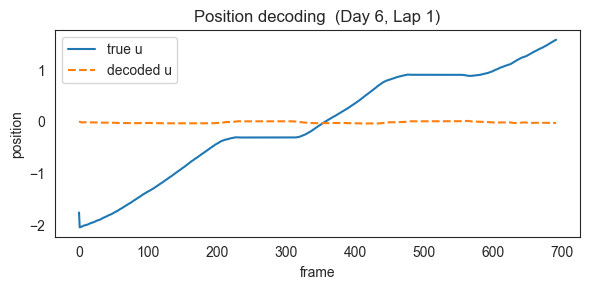

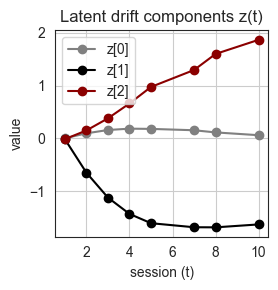

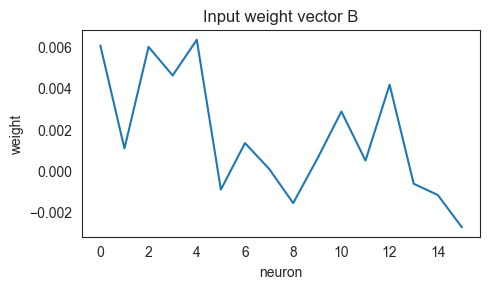

In [233]:
# ============================================================
#  DESTINODE – sanity‑check notebook cell
# ============================================================
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np

# ------------ 1) hold‑out lap decoding quality --------------
# pick Day 6 • Lap 1  (change indices if you prefer)
lap_idx_test = 1
x_true_ho = x_sess[test_day][lap_idx_test].to(device)
v_true_ho = v_sess[test_day][lap_idx_test].to(device)
u_true_ho = u_sess[test_day][lap_idx_test].cpu().numpy()
K_ho       = v_true_ho.size(0)

# run network with learned W(test_day)
W_td = model.weights(T)[test_day]
x_pred_ho = [x_true_ho[0]]
for k in range(K_ho-1):
    x_pred_ho.append(model.rnn_cell(x_pred_ho[-1], v_true_ho[k], W_td))
x_pred_ho = torch.stack(x_pred_ho)
u_pred_ho = (model.R @ x_pred_ho.T).squeeze().detach().cpu().numpy()

# R²
r2 = r2_score(u_true_ho, u_pred_ho)
print(f"Held‑out Lap  R² = {r2:.3f}")

# plot
plt.figure(figsize=(6,3))
plt.plot(u_true_ho, label='true u'); plt.plot(u_pred_ho,'--', label='decoded u')
plt.title(f"Position decoding  (Day {test_day}, Lap {lap_idx_test})")
plt.xlabel("frame"); plt.ylabel("position"); plt.legend(); plt.tight_layout(); plt.show()



# ------------ 2) latent drift trajectory z(t) ---------------

T_day_label = [1,2,3,4,5,7,8,10]

with torch.no_grad():
    t_axis = torch.arange(T, dtype=torch.float32, device=device)
    z_traj = odeint(model.slow, model.z0.unsqueeze(0), t_axis).squeeze(1).cpu().numpy()

plt.figure(figsize=(3,3))
colors = [ 'gray', 'black','darkred']
for i in range(z_traj.shape[1]):
    plt.plot(T_day_label, z_traj[:, i], '-o', label=f'z[{i}]', color=colors[i])
plt.title("Latent drift components z(t)")
plt.xlabel("session (t)"); plt.ylabel("value"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


# ------------ 3) input‑weight pattern B ---------------------
B_np = model.B.detach().cpu().numpy().squeeze()   # shape [N]
plt.figure(figsize=(5,3))
plt.plot(B_np)
plt.title("Input weight vector B")
plt.xlabel("neuron"); plt.ylabel("weight"); plt.tight_layout(); plt.show()


In [140]:
T

8

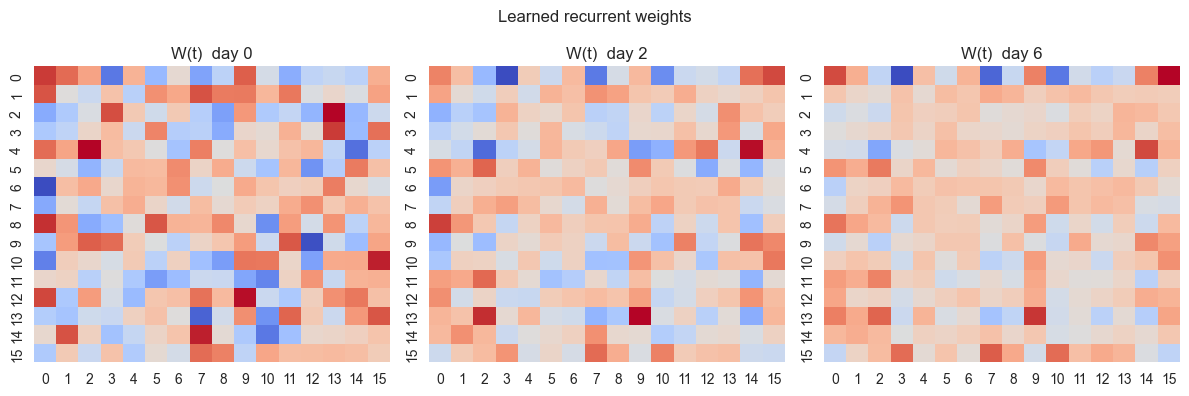

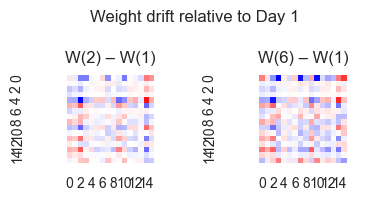

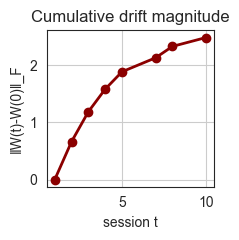

In [247]:
# ============================================================
#  Weight‑matrix diagnostics  (heat‑maps & drift magnitude)
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
T_day_label = [1,2,3,4,5,7,8,10]
Ws_np = model.weights(T).detach().cpu().numpy()   # shape [T, N, N]

# ---------- 1) absolute matrices ----------
days_to_show = [0, train_days[-2], test_day]      # Day0, Day3, Day6
fig, axes = plt.subplots(1, len(days_to_show), figsize=(4*len(days_to_show),4))
for ax, t in zip(axes, days_to_show):
    sns.heatmap(Ws_np[t], ax=ax, cmap='coolwarm', cbar=False)
    ax.set_title(f"W(t)  day {t}")
plt.suptitle("Learned recurrent weights"); plt.tight_layout(); plt.show()

# ---------- 2) differences  W(t) - W(0) ----------
fig, axes = plt.subplots(1, len(days_to_show)-1, figsize=(2*(len(days_to_show)-1),2))
for ax, t in zip(axes, days_to_show[1:]):
    diff = Ws_np[t] - Ws_np[0]
    sns.heatmap(diff, ax=ax, cmap='bwr', center=0, cbar=False)
    ax.set_title(f"W({t}) – W(1)")
    ax.axis('equal')
plt.suptitle("Weight drift relative to Day 1"); plt.tight_layout(); plt.show()

# ---------- 3) Frobenius‑norm drift magnitude ----------
fro_norm = [np.linalg.norm(Ws_np[t] - Ws_np[0]) for t in range(T)]
plt.figure(figsize=(2.5,2.5))
plt.plot(T_day_label,fro_norm, '-o', color = 'darkred',linewidth = 2); plt.xlabel('session t'); plt.ylabel('‖W(t)-W(0)‖_F')
plt.title("Cumulative drift magnitude"); plt.grid(True); plt.tight_layout(); plt.show()


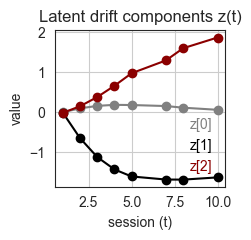

In [246]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.figure(figsize=(2.5, 2.5))
colors = ['gray', 'black', 'darkred']
for i in range(z_traj.shape[1]):
    plt.plot(T_day_label, z_traj[:, i], '-o', color=colors[i])

# Create custom legend handles with matching text color
custom_legend = [
    Line2D([0], [0], linestyle='None', marker='', color=colors[0], label='z[0]'),
    Line2D([0], [0], linestyle='None', marker='', color=colors[1], label='z[1]'),
    Line2D([0], [0], linestyle='None', marker='', color=colors[2], label='z[2]')
]

legend = plt.legend(handles=custom_legend, loc='lower right', frameon=False)
# Match legend text color to corresponding line
for text, color in zip(legend.get_texts(), colors):
    text.set_color(color)

plt.title("Latent drift components z(t)")
plt.xlabel("session (t)")
plt.ylabel("value")
plt.grid(True)
plt.tight_layout()
plt.show()


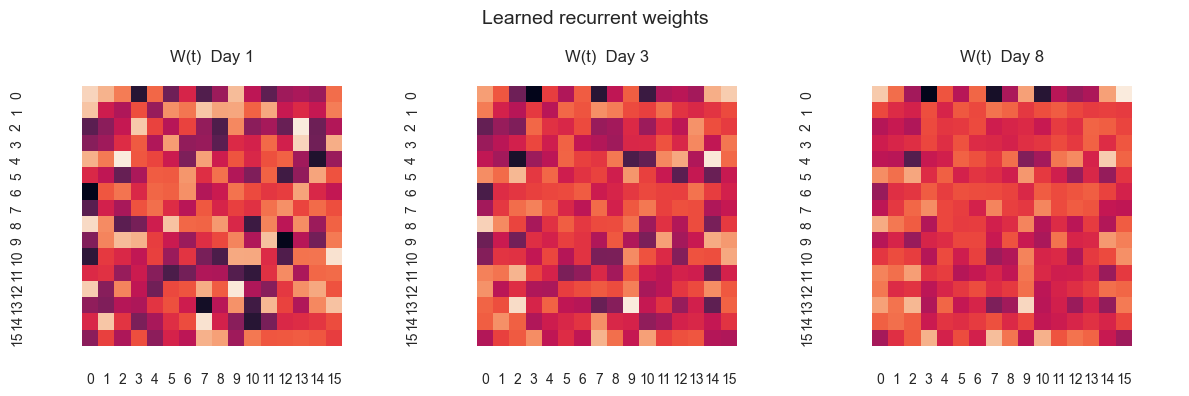

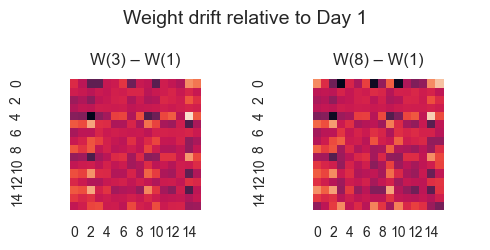

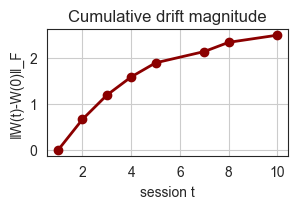

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("white")

T_day_label = [1,2,3,4,5,7,8,10]
Ws_np = model.weights(T).detach().cpu().numpy()   # shape [T, N, N]

# ---------- 1) Absolute weight matrices ----------
days_to_show = [0, train_days[-2], test_day]  # Day0, Day3, Day6
fig, axes = plt.subplots(1, len(days_to_show), figsize=(4*len(days_to_show), 4))
for ax, t in zip(axes, days_to_show):
    sns.heatmap(Ws_np[t], ax=ax, cmap='rocket', cbar=False)
    ax.set_title(f"W(t)  Day {T_day_label[t]}")
    ax.axis('equal')
plt.suptitle("Learned recurrent weights", fontsize=14)
plt.tight_layout(); plt.show()

# ---------- 2) Differences W(t) - W(0) ----------
fig, axes = plt.subplots(1, len(days_to_show)-1, figsize=(2.5*(len(days_to_show)-1), 2.5))
for ax, t in zip(axes, days_to_show[1:]):
    diff = Ws_np[t] - Ws_np[0]
    sns.heatmap(diff, ax=ax, cmap='rocket', center=0, cbar=False)
    ax.set_title(f"W({T_day_label[t]}) – W(1)")
    ax.axis('equal')
plt.suptitle("Weight drift relative to Day 1", fontsize=14)
plt.tight_layout(); plt.show()

# ---------- 3) Frobenius-norm drift magnitude ----------
fro_norm = [np.linalg.norm(Ws_np[t] - Ws_np[0]) for t in range(T)]
plt.figure(figsize=(3.2, 2.2))
plt.plot(T_day_label, fro_norm, '-o', color='darkred', linewidth=2)
plt.xlabel('session t'); plt.ylabel('‖W(t)-W(0)‖_F')
plt.title("Cumulative drift magnitude", fontsize=12)
plt.grid(True); plt.tight_layout(); plt.show()


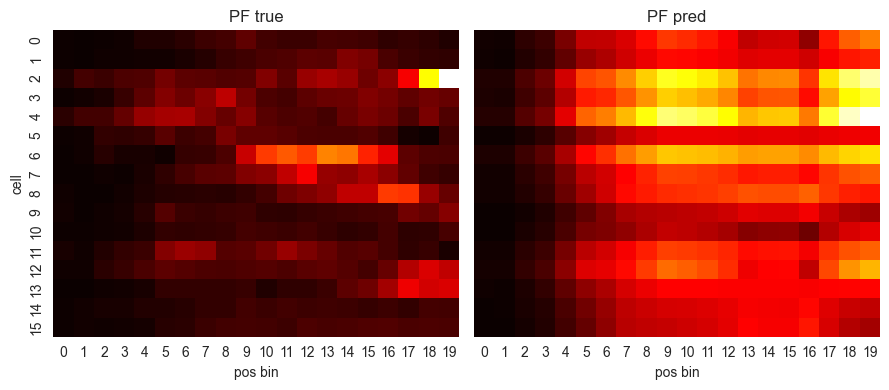

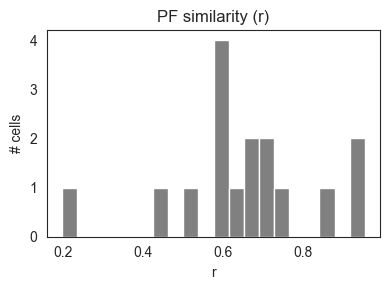

PF r mean=0.652 ± 0.045
PC decoder R²  true=0.910   pred=0.593


In [156]:
# ===============================================================
#  ADVANCED VISUALS + METRICS  (with optional lap‑averaging)
# ===============================================================
import numpy as np, torch, matplotlib.pyplot as plt, seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
sns.set_style("white")

# ------------------ 0. KNOBS ------------------
REST_DAY      = 2      # which session to analyse
LAP_ID        = 3      # ignored if AVG_OVER_LAPS = True
NUM_BINS      = 20
AVG_OVER_LAPS = True   # <- turn ON to average across all laps on REST_DAY

# ------------------ 1. COLLECT / AVERAGE  ---------------------
Ws = model.weights(T)
W_day = Ws[REST_DAY]

def reconstruct(lap_idx):
    x_t = x_sess[REST_DAY][lap_idx].to(device)
    v_t = v_sess[REST_DAY][lap_idx].to(device)
    u_t = u_sess[REST_DAY][lap_idx].cpu().numpy()
    K   = v_t.size(0)
    with torch.no_grad():
        x_p=[x_t[0]]
        for k in range(K-1):
            x_p.append(model.rnn_cell(x_p[-1], v_t[k], W_day))
        x_p  = torch.stack(x_p).cpu()                    # [K,N]
        u_p  = (model.R @ x_p.T).squeeze().cpu().numpy() # [K]
    return x_t.cpu(), x_p, u_t, u_p, K

if AVG_OVER_LAPS:
    all_x_true = []; all_x_pred = []; all_u_true = []; all_u_pred = []
    K_max = max(len(v) for v in v_sess[REST_DAY])
    for li in range(len(x_sess[REST_DAY])):
        xT,xP,uT,uP,K = reconstruct(li)
        pad = (K_max-K,0)  # pad at *front* so starts align
        all_x_true.append(torch.nn.functional.pad(xT, pad=(0,0,*pad)))
        all_x_pred.append(torch.nn.functional.pad(xP, pad=(0,0,*pad)))
        all_u_true.append(np.pad(uT, pad, constant_values=np.nan))
        all_u_pred.append(np.pad(uP, pad, constant_values=np.nan))
    x_true = torch.stack(all_x_true).nanmean(0)   # [K_max,N]
    x_pred = torch.stack(all_x_pred).nanmean(0)
    u_true = np.nanmean(np.vstack(all_u_true),0)
    u_pred = np.nanmean(np.vstack(all_u_pred),0)
    K_seq  = K_max
else:  # single lap path
    x_true,x_pred,u_true,u_pred,K_seq = reconstruct(LAP_ID)[:5]




# ------------------ 6. Place‑field maps ----------------------
pos_bins=np.linspace(u_true.min(),u_true.max(),NUM_BINS+1)
bin_idx=np.digitize(u_true,pos_bins)-1
def pf(x):
    P=np.zeros((NUM_BINS,x.shape[1]))
    for b in range(NUM_BINS):
        if not (bin_idx==b).any(): continue
        P[b]=x[bin_idx==b].mean(0)
    return P.T
pf_true,pf_pred = pf(x_true.numpy()), pf(x_pred.numpy())

fig,axs=plt.subplots(1,2,figsize=(9,4),sharey=True)
sns.heatmap(pf_true,ax=axs[0],cmap='hot',cbar=False);axs[0].set_title('PF true')
sns.heatmap(pf_pred,ax=axs[1],cmap='hot',cbar=False);axs[1].set_title('PF pred')
for ax in axs: ax.set_xlabel('pos bin'); axs[0].set_ylabel('cell')
plt.tight_layout(); plt.show()

# ------------------ 7. PF similarity histogram --------------
corrs=[pearsonr(pf_true[i],pf_pred[i])[0]
       for i in range(pf_true.shape[0]) if pf_true[i].std() and pf_pred[i].std()]
plt.figure(figsize=(4,3)); plt.hist(corrs,bins=20,color='gray')
plt.title('PF similarity (r)'); plt.xlabel('r'); plt.ylabel('# cells'); plt.tight_layout(); plt.show()
print(f"PF r mean={np.mean(corrs):.3f} ± {np.std(corrs)/np.sqrt(len(corrs)):.3f}")

# ------------------ 8. PCA‑decoder accuracy ------------------
reg = LinearRegression().fit(true_p2, u_true)
print(f"PC decoder R²  true={r2_score(u_true, reg.predict(true_p2)):.3f}   "
      f"pred={r2_score(u_true, reg.predict(pred_p2)):.3f}")



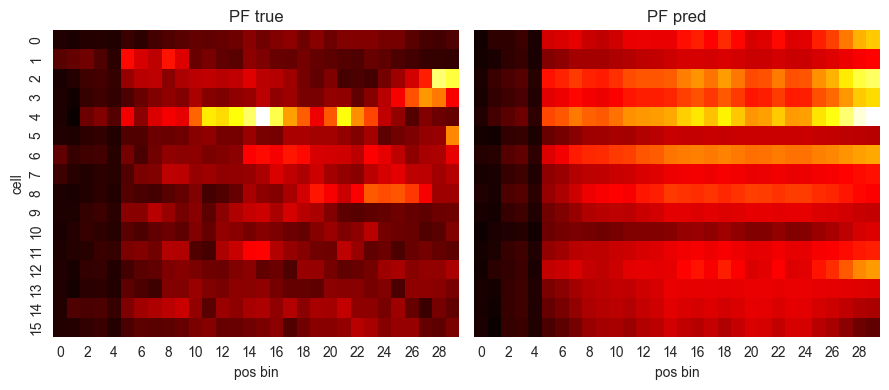

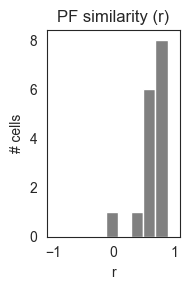

PF r mean=0.645 ± 0.061


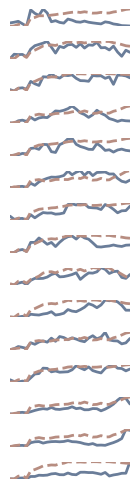

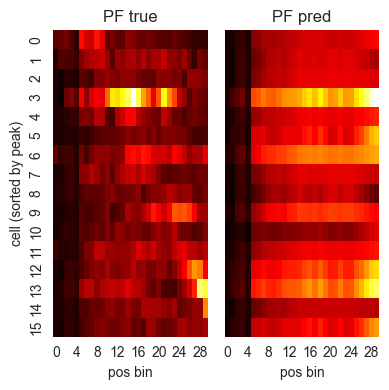

In [251]:
# ===============================================================
#  ADVANCED VISUALS + METRICS  (with optional lap‑averaging)
# ===============================================================
import numpy as np, torch, matplotlib.pyplot as plt, seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
sns.set_style("white")

# ------------------ 0. KNOBS ------------------
REST_DAY      = 1      # which session to analyse
LAP_ID        = 3      # ignored if AVG_OVER_LAPS = True
NUM_BINS      = 30
AVG_OVER_LAPS = True   # <- turn ON to average across all laps on REST_DAY

# ------------------ 1. COLLECT / AVERAGE  ---------------------
Ws = model.weights(T)
W_day = Ws[REST_DAY]

def reconstruct(lap_idx):
    x_t = x_sess[REST_DAY][lap_idx].to(device)
    v_t = v_sess[REST_DAY][lap_idx].to(device)
    u_t = u_sess[REST_DAY][lap_idx].cpu().numpy()
    K   = v_t.size(0)
    with torch.no_grad():
        x_p=[x_t[0]]
        for k in range(K-1):
            x_p.append(model.rnn_cell(x_p[-1], v_t[k], W_day))
        x_p  = torch.stack(x_p).cpu()                    # [K,N]
        u_p  = (model.R @ x_p.T).squeeze().cpu().numpy() # [K]
    return x_t.cpu(), x_p, u_t, u_p, K

if AVG_OVER_LAPS:
    all_x_true = []; all_x_pred = []; all_u_true = []; all_u_pred = []
    K_max = max(len(v) for v in v_sess[REST_DAY])
    for li in range(len(x_sess[REST_DAY])):
        xT,xP,uT,uP,K = reconstruct(li)
        pad = (K_max-K,0)  # pad at *front* so starts align
        all_x_true.append(torch.nn.functional.pad(xT, pad=(0,0,*pad)))
        all_x_pred.append(torch.nn.functional.pad(xP, pad=(0,0,*pad)))
        all_u_true.append(np.pad(uT, pad, constant_values=np.nan))
        all_u_pred.append(np.pad(uP, pad, constant_values=np.nan))
    x_true = torch.stack(all_x_true).nanmean(0)   # [K_max,N]
    x_pred = torch.stack(all_x_pred).nanmean(0)
    u_true = np.nanmean(np.vstack(all_u_true),0)
    u_pred = np.nanmean(np.vstack(all_u_pred),0)
    K_seq  = K_max
else:  # single lap path
    x_true,x_pred,u_true,u_pred,K_seq = reconstruct(LAP_ID)[:5]




# ------------------ 6. Place‑field maps ----------------------
pos_bins=np.linspace(u_true.min(),u_true.max(),NUM_BINS+1)
bin_idx=np.digitize(u_true,pos_bins)-1
def pf(x):
    P=np.zeros((NUM_BINS,x.shape[1]))
    for b in range(NUM_BINS):
        if not (bin_idx==b).any(): continue
        P[b]=x[bin_idx==b].mean(0)
    return P.T
pf_true,pf_pred = pf(x_true.numpy()), pf(x_pred.numpy())

fig,axs=plt.subplots(1,2,figsize=(9,4),sharey=True)
sns.heatmap(pf_true,ax=axs[0],cmap='hot',cbar=False);axs[0].set_title('PF true')
sns.heatmap(pf_pred,ax=axs[1],cmap='hot',cbar=False);axs[1].set_title('PF pred')
for ax in axs: ax.set_xlabel('pos bin'); axs[0].set_ylabel('cell')
plt.tight_layout(); plt.show()







# ------------------ 7. PF similarity histogram --------------
corrs=[pearsonr(pf_true[i],pf_pred[i])[0]
       for i in range(pf_true.shape[0]) if pf_true[i].std() and pf_pred[i].std()]
plt.figure(figsize=(2,3))
plt.hist(corrs,bins=5,color='gray')
plt.title('PF similarity (r)'); plt.xlabel('r'); plt.xlim([-1.1,1.1]);plt.ylabel('# cells'); plt.tight_layout(); plt.show()
print(f"PF r mean={np.mean(corrs):.3f} ± {np.std(corrs)/np.sqrt(len(corrs)):.3f}")








# ===============================================================
#  PRETTIER PF‑OVERLAY GRID   (bug‑fixed)
# ===============================================================
def plot_pf_overlays(pf_true, pf_pred,
                     cells_to_show=15, cols=1, title=""):

    import numpy as np, matplotlib.pyplot as plt, seaborn as sns
    sns.set_style("white")

    # 1) normalise 0‑1 per cell
    def minmax(a):
        mn=a.min(1,keepdims=True); mx=a.max(1,keepdims=True)
        return (a-mn)/(mx-mn+1e-9)
    pfT = minmax(pf_true);  pfP = minmax(pf_pred)

    # 2) sort by peak of true
    order = np.argsort(np.argmax(pf_true,1))
    pfT, pfP = pfT[order], pfP[order]

    # 3) subset
    pfT, pfP = pfT[:cells_to_show], pfP[:cells_to_show]

    # 4) plot
    rows = int(np.ceil(cells_to_show/cols))
    fig,ax_arr = plt.subplots(rows, cols,
                              figsize=(cols*1.5, 5),
                              squeeze=False,
                              sharex=True, sharey=True)
    xb = np.arange(pfT.shape[1])

    true_color = (106/255, 125/255, 153/255)
    pred_color = (183/255, 141/255, 129/255)

    for idx in range(cells_to_show):
        r,c = divmod(idx, cols)
        ax  = ax_arr[r,c]
        ax.plot(xb, pfT[idx], color=true_color, lw=2)
        ax.plot(xb, pfP[idx], '--', color=pred_color, lw=2)
        ax.set_xlim(0, pfT.shape[1]-1); ax.set_ylim(0,1)
        ax.set_xticks([]); ax.set_yticks([])
        # ax.set_title(f'cell {order[idx]}', fontsize=7, pad=2)
        # -------- fixed: hide spines properly --------
        for sp in ax.spines.values():
            sp.set_visible(False)
        ax.grid(alpha=0.15)

    # hide empty panels
    for ax in ax_arr.ravel()[cells_to_show:]:
        ax.axis('off')

    # tiny legend
    l_ax = ax_arr[0,-1]
    l_ax.plot([],[],color='tab:red',label='true',lw=2)
    l_ax.plot([],[],color='tab:blue',ls='--',label='pred',lw=2)
    # l_ax.legend(frameon=False, fontsize=7, loc='upper left')

    # fig.suptitle(title, y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

# ---------- call it ----------
plot_pf_overlays(
    pf_true, pf_pred,
    cells_to_show=15, cols=1,
    title=f"Place field Day {REST_DAY}  "
          f'{"avg of laps" if AVG_OVER_LAPS else f"lap {LAP_ID}"}')





# ------------------ 6. Place‑field maps (now ordered) ----------------------
pos_bins = np.linspace(u_true.min(), u_true.max(), NUM_BINS+1)
bin_idx  = np.digitize(u_true, pos_bins) - 1

def pf(x):
    P = np.zeros((NUM_BINS, x.shape[1]))
    for b in range(NUM_BINS):
        if (bin_idx == b).any():
            P[b] = x[bin_idx == b].mean(0)
    return P.T                                            # [cells, pos‑bin]

pf_true, pf_pred = pf(x_true.numpy()), pf(x_pred.numpy())

# ---- 1) sort cells exactly as in the overlay plot ----
order   = np.argsort(np.argmax(pf_true, axis=1))          # peak‑location sort
pf_true = pf_true[order]
pf_pred = pf_pred[order]

# ---- 2) heatmaps with the same cell order ----
fig, axs = plt.subplots(1, 2, figsize=(4, 4), sharey=True)
sns.heatmap(pf_true, ax=axs[0], cmap='hot',  cbar=False); axs[0].set_title('PF true')
sns.heatmap(pf_pred, ax=axs[1], cmap='hot',  cbar=False); axs[1].set_title('PF pred')
for ax in axs:
    ax.set_xlabel('pos bin')
axs[0].set_ylabel('cell (sorted by peak)')
plt.tight_layout(); plt.show()



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.draw()
/var/folde

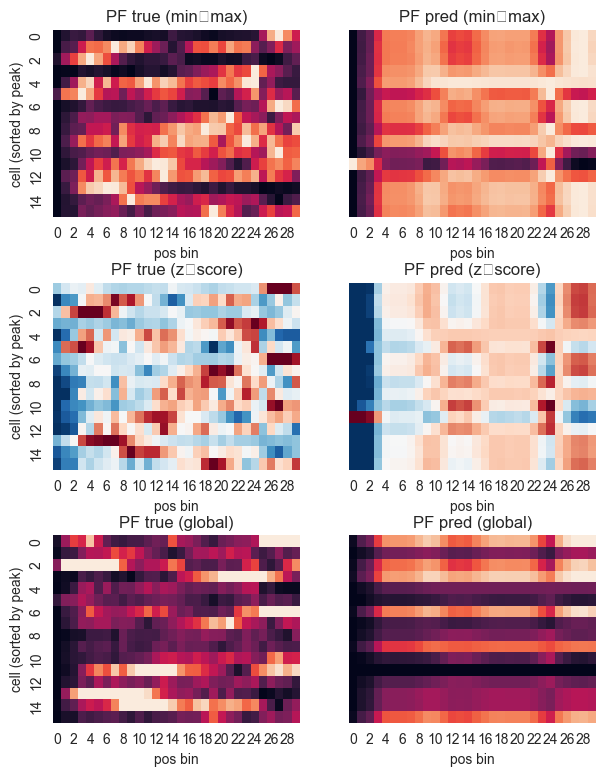

In [220]:
# ============================================================
#  Unified PF‑heatmap visualiser: min‑max | z‑score | global
# ============================================================
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
sns.set_style("white")

def minmax(a):
    mn = a.min(1, keepdims=True)
    mx = a.max(1, keepdims=True)
    return (a - mn) / (mx - mn + 1e-9)

def zscore(a):
    mu = a.mean(1, keepdims=True)
    sd = a.std(1, keepdims=True) + 1e-9
    return (a - mu) / sd

def build_heatmaps(pf_true, pf_pred, order):
    """Show three comparable heatmaps for place‑fields:
       1) per‑cell min‑max (0–1)
       2) per‑cell z‑score (diverging palette)
       3) raw values, shared global limits.
    """
    # ––– reorder according to overlay plot –––
    pfT = pf_true[order]
    pfP = pf_pred[order]
    
    # 1) min‑max 0‑1
    pfT_minmax = minmax(pfT)
    pfP_minmax = minmax(pfP)
    
    # 2) z‑score
    pfT_z = zscore(pfT)
    pfP_z = zscore(pfP)
    
    # 3) global limits (5th–95th pct for robustness)
    vmin = np.percentile(np.hstack([pfT, pfP]), 5)
    vmax = np.percentile(np.hstack([pfT, pfP]), 95)
    
    # ––– plotting –––
    fig, axs = plt.subplots(3, 2, figsize=(7, 9), sharey=True,
                            gridspec_kw={"hspace":0.35})
    titles = ['PF true', 'PF pred']
    
    # --- row 0 : min‑max ---
    for j,(data,t) in enumerate([(pfT_minmax,titles[0]), (pfP_minmax,titles[1])]):
        sns.heatmap(data, ax=axs[0,j], cmap='rocket',
                    vmin=0, vmax=1, cbar=False)
        axs[0,j].set_title(f"{t} (min‑max)")
    
    # --- row 1 : z‑score ---
    for j,(data,t) in enumerate([(pfT_z,titles[0]), (pfP_z,titles[1])]):
        sns.heatmap(data, ax=axs[1,j], cmap='RdBu_r',
                    center=0, vmin=-2, vmax=2, cbar=False)
        axs[1,j].set_title(f"{t} (z‑score)")
    
    # --- row 2 : global scale ---
    for j,(data,t) in enumerate([(pfT,titles[0]), (pfP,titles[1])]):
        sns.heatmap(data, ax=axs[2,j], cmap='rocket',
                    vmin=vmin, vmax=vmax, cbar=False)
        axs[2,j].set_title(f"{t} (global)")
    
    # shared labels
    for ax in axs.ravel():
        ax.set_xlabel('pos bin')
    for i in range(3):
        axs[i,0].set_ylabel('cell (sorted by peak)')
    
    plt.tight_layout()
    plt.show()

# -------- call once --------
build_heatmaps(pf_true, pf_pred, order)


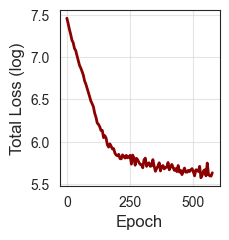

In [249]:
import matplotlib.pyplot as plt
import numpy as np

# Manually input the epoch and total loss values
epochs = np.arange(0, 576, 5)
loss_total = [
    1741, 1636, 1526, 1439, 1343, 1302, 1218, 1186, 1118, 1054,
    996, 964, 927, 887, 829, 798, 759, 723, 687, 652,
    632, 609, 565, 539, 503, 495, 481, 460, 461, 423,
    433, 421, 389, 378, 393, 382, 370, 371, 352, 344,
    341, 347, 330, 329, 345, 338, 332, 343, 333, 336,
    343, 309, 344, 333, 305, 331, 325, 315, 308, 307,
    296, 325, 332, 301, 310, 314, 301, 303, 326, 302,
    284, 294, 302, 314, 285, 301, 304, 292, 297, 298,
    315, 289, 299, 308, 297, 287, 293, 283, 304, 281,
    287, 273, 284, 295, 281, 281, 287, 283, 289, 293,
    282, 269, 289, 288, 283, 301, 263, 271, 285, 289,
    269, 313, 273, 269, 268, 279
]

# Create the plot
plt.figure(figsize=(2.5, 2.5))
plt.plot(epochs, np.log(loss_total), linewidth=2, color='darkred')
# plt.scatter(epochs, loss_total, color='gray', edgecolor='black', zorder=5, s=4)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Total Loss (log)", fontsize=12)
plt.grid(True, linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()
